# Sprint 3

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from fastai.vision.all import PILImage

2022-12-13 14:38:42.571611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 14:38:42.970286: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 14:38:44.500036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 14:38:44.500188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Checking if gpu is available

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10039361747801649937
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10910760960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8996083120250294574
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3c:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-12-13 14:38:52.017839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 14:38:53.987899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3c:00.0, compute capability: 6.1


Loading dataset

In [3]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_test = X_test.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

IMG_HEIGHT = 128
IMG_WIDTH = 128
img_folder = "tripadvisor_dataset/tripadvisor_images_small"

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np = np.array(img_resized) #.reshape((IMG_HEIGHT,IMG_WIDTH, 3)) #.astype(np.float32)
        images[i]=img_np/255
    return images

images = create_dataset(img_folder)
images_length = len(images)
X_train_full = images
X_train_full.shape

(15182, 128, 128, 3)

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


conv_encoder = keras.models.Sequential([
    # keras.layers.Reshape([128, 128, 3], input_shape=[128, 128, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"), 
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu", input_shape=[16, 16, 128]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])


conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train_full, X_train_full, epochs=10)

# print(conv_encoder.summary())
# conv_decoder.summary()




2022-12-13 14:40:28.056661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3c:00.0, compute capability: 6.1
2022-12-13 14:40:35.555336: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2984902656 exceeds 10% of free system memory.
2022-12-13 14:40:47.305702: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2984902656 exceeds 10% of free system memory.
2022-12-13 14:41:02.752326: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2984902656 exceeds 10% of free system memory.
2022-12-13 14:41:07.696944: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2984902656 exceeds 10% of free system memory.


Epoch 1/10


2022-12-13 14:41:25.637930: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


475/475 [==============================] - 35s 58ms/step - loss: 0.5609 - rounded_accuracy: 0.8608
Epoch 2/10
475/475 [==============================] - 16s 34ms/step - loss: 0.5381 - rounded_accuracy: 0.9045
Epoch 3/10
475/475 [==============================] - 16s 35ms/step - loss: 0.5347 - rounded_accuracy: 0.9112
Epoch 4/10
475/475 [==============================] - 16s 34ms/step - loss: 0.5326 - rounded_accuracy: 0.9159
Epoch 5/10
475/475 [==============================] - 17s 35ms/step - loss: 0.5309 - rounded_accuracy: 0.9194
Epoch 6/10
475/475 [==============================] - 15s 32ms/step - loss: 0.5298 - rounded_accuracy: 0.9217
Epoch 7/10
475/475 [==============================] - 15s 32ms/step - loss: 0.5288 - rounded_accuracy: 0.9238
Epoch 8/10
475/475 [==============================] - 17s 37ms/step - loss: 0.5282 - rounded_accuracy: 0.9250
Epoch 9/10
475/475 [==============================] - 16s 33ms/step - loss: 0.5275 - rounded_accuracy: 0.9266
Epoch 10/10
475/475 [

1/1 [==============================] - 0s 473ms/step


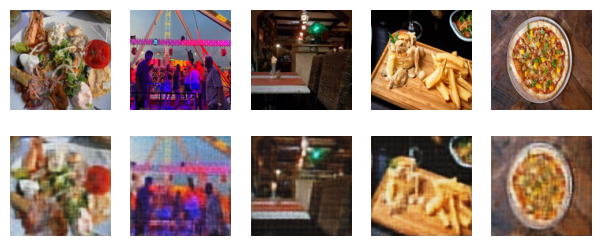

In [5]:
import matplotlib.pyplot as plt


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images=X_train_full, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(conv_ae)

plt.show()


In [6]:
X_train_full[:1].shape

(1, 128, 128, 3)

## Save model

In [7]:
conv_ae.save('./model/')


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets
